# Normalization Test
This notebook scales the amplitude

## Imports
This notebook uses the custom code found in the code folder

In [1]:
import os

# math, processing, deep learning
import numpy as np
import tensorflow as tf
from scipy.signal import stft, istft

# visualization
import matplotlib.pyplot as plt
from ipywidgets import interact
from mpl_toolkits.axes_grid1 import make_axes_locatable


# custom code
from code.stftprocessing import StftDataset
from code.dsvisual import DatasetVisualizer

# convenience
from tqdm import tqdm
import datetime


2023-04-26 14:14:33.358133: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Load the files for training and testing
There are different training and test sets in the folder. This section loads the appropriate ones into memory.


In [2]:
# this is a smaller training set for testing purposes
folder = "training/new_small"
base = "noisy_small"
target = "pure_small"

# this is a training set for training the main model
# folder = "training/original training"
# base = "noisy"
# target = "pure"

test_folder = "training/test set"
test_base = "noisy_test"
test_target = "pure_test"


Load the files from the given locations using the custom code StftDataset class.

The StftDataset class also processes the waveforms into STFT format.

In [3]:
noisy_stft = StftDataset()
pure_stft = StftDataset()

noisy_stft.load(folder, base)
pure_stft.load(folder, target)

# test sets
noisy_test_stft = StftDataset()
pure_test_stft = StftDataset()
noisy_test_stft.load(test_folder, test_base)
pure_test_stft.load(test_folder, test_target)

Files loaded.
Files loaded.
Files loaded.
Files loaded.


In [4]:
# get the amplitudes of training and test sets
examples = noisy_stft.get_data()[:,:,:,:]
labels = pure_stft.get_data()[:,:,:,:]

In [5]:
t = noisy_stft.t
f = noisy_stft.f

## Get an example
Get an example from the noisy and clean datasets.

In [6]:
# set index of examples to get
index =0
# get examples from noisy and label set
test_example = examples[index]
label_example = labels[index]

## Process the example
Convert the data into complex-valued data and invert the STFT

In [7]:
# convert the amplitude and phase data into complex valued data
test_example_complex = test_example[:,:,0]*np.exp(1j* test_example[:,:,1])
label_example_complex = label_example[:,:,0]*np.exp(1j* label_example[:,:,1])

In [8]:
# invert the STFT data
t, wave = istft(test_example_complex, fs=5.)
t, wave_pure = istft(label_example_complex, fs=5.)

## Plot
Plot the results.

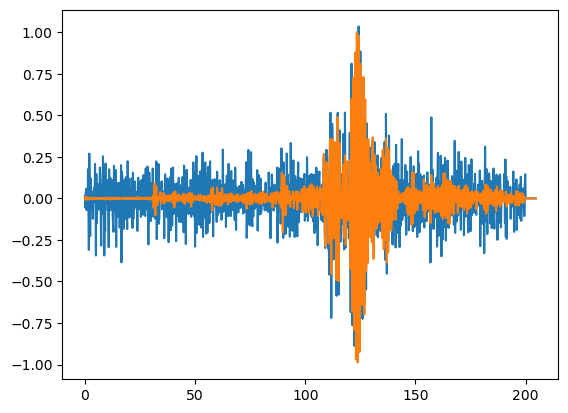

In [9]:
plt.plot(t, wave)
plt.plot(t, wave_pure)

## Filter 
Select only the amplitude values above threshold

In [10]:
amplitude_threshold = 0.01
filtered_example = np.where(test_example[:,:,0] > amplitude_threshold,test_example[:,:,0], 0)

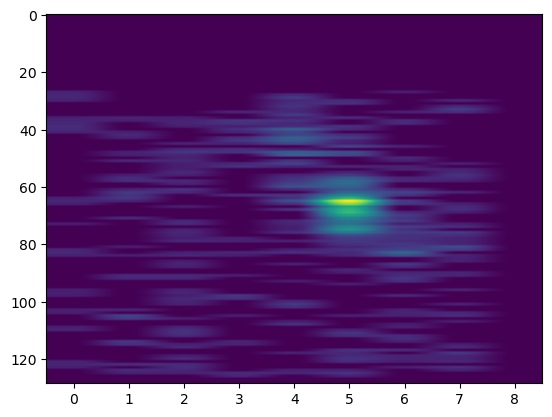

In [11]:
plt.imshow(filtered_example, aspect="auto")

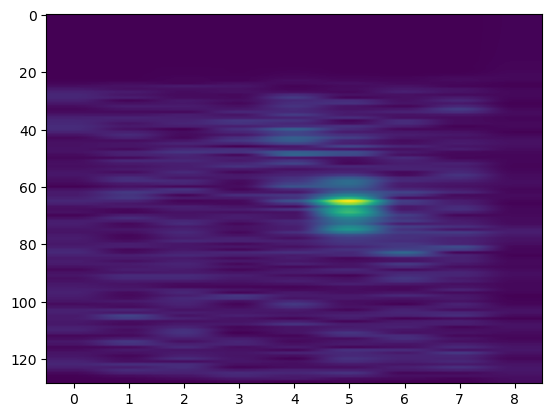

In [12]:
plt.imshow(test_example[:,:,0], aspect="auto")

In [13]:
filtered_example = np.where(test_example[:,:,0] > 0.0175,test_example[:,:,0], 0)

In [14]:
test_example_complex_filtered = filtered_example[:,:]*np.exp(1j* test_example[:,:,1])

In [15]:
test_example_complex.shape

(129, 9)

In [16]:
t, new_wave = istft(test_example_complex_filtered, fs=5.)

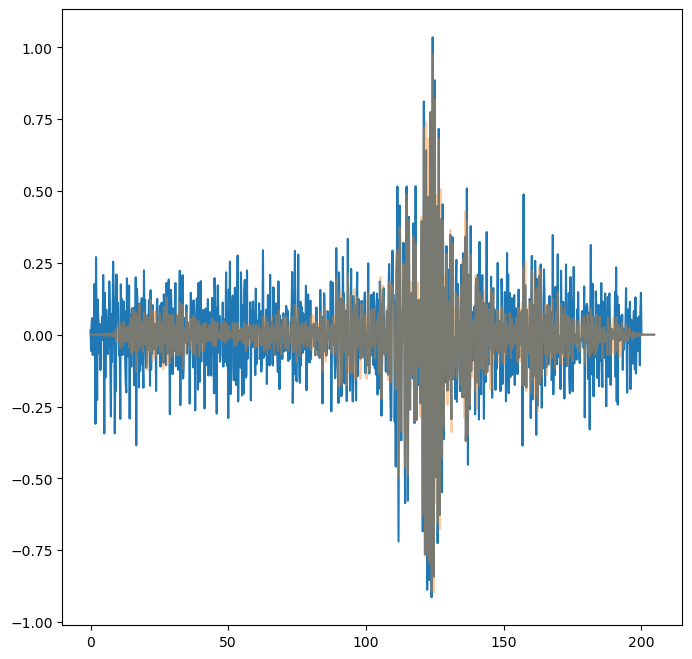

In [17]:
plt.figure(figsize=(8,8))
plt.plot(t, wave)
plt.plot(t, new_wave,alpha=0.4)


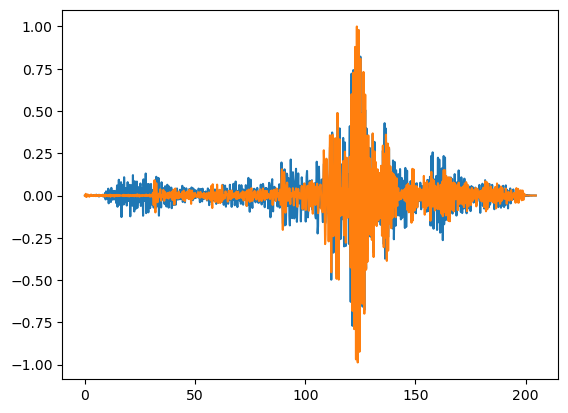

In [18]:
plt.plot(t, new_wave)
plt.plot(t, wave_pure)

In [19]:
maximum_amp =np.max(examples[:,:,:,0], axis=(-1,-2))

In [20]:
examples.shape

(10000, 129, 9, 2)

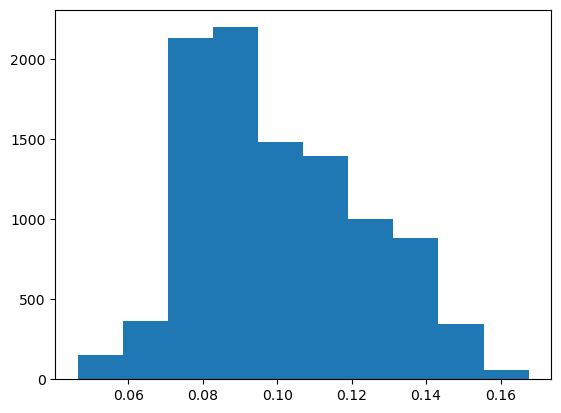

In [21]:
plt.hist(maximum_amp)
plt.show()

In [22]:
np.sqrt(np.var(maximum_amp))

0.022943028584786872

## Testing a scaled output
The phase values of an STFT as implemented by scipy are in the range of [-3.14, 3.14].

Typical output values however, are only between 0 and 1. The output needs to be scaled.

In [23]:
# Define custom activation function
def custom_activation(x):
    return 3.14 * tf.tanh(x)



In [24]:
# Define model with custom activation function
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation=custom_activation),
    tf.keras.layers.Dense(32, activation=custom_activation),
    tf.keras.layers.Dense(1)
])

# Compile model with appropriate loss function and optimizer
model.compile(loss='mse', optimizer='adam')



2023-04-26 14:15:35.921878: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-26 14:15:35.924137: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-04-26 14:15:35.947808: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-26 14:15:35.947996: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: NVIDIA GeForce GTX 970 computeCapability: 5.2
coreClock: 1.253GHz coreCount: 13 deviceMemorySize: 3.93GiB deviceMemoryBandwidth: 208.91GiB/s
2023-04-26 14:15:35.948008: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-04-26 14:15:35.988613: I tensorflow/stream_executor/platform/def

In [26]:
# Train model with your data
# model.fit(x_train, y_train, epochs=10, batch_size=32)

In [59]:
# test the layer on an input
layer_with_custom_activation = tf.keras.layers.Dense(10, activation=custom_activation)



In [63]:
x = np.linspace(0,1,32)
x = x.reshape(32,1)

In [68]:
output = layer_with_custom_activation(x)

In [70]:
output.shape

TensorShape([32, 10])

In [49]:
layer_with_custom_activation([10,])

ValueError: Input 0 of layer dense_4 is incompatible with the layer: : expected min_ndim=2, found ndim=0. Full shape received: ()

In [71]:
test_example.shape

(129, 9, 2)

In [74]:
test_example_amp = test_example[:,:,0]
test_example_phase = test_example[:,:,1]

In [85]:
tf.stack((test_example_amp,test_example_phase), axis=-1).shape

TensorShape([129, 9, 2])

## Testing Rescaling
There is an experimental rescaling layer in the experimental layers module.

Documentation at https://www.tensorflow.org/versions/r2.4/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling

The problem remains that rescaling the whole output would give conflicting results.

In [93]:
rescaler = tf.keras.layers.experimental.preprocessing.Rescaling(scale=3.14)

In [94]:
rescaler_x = np.linspace(-1.,1.,32)
rescaler(rescaler_x)

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([-3.14      , -2.9374194 , -2.7348387 , -2.5322583 , -2.3296776 ,
       -2.127097  , -1.9245162 , -1.7219356 , -1.5193548 , -1.3167742 ,
       -1.1141936 , -0.9116129 , -0.70903224, -0.5064516 , -0.30387098,
       -0.10129032,  0.10129032,  0.30387098,  0.5064516 ,  0.70903224,
        0.9116129 ,  1.1141936 ,  1.3167742 ,  1.5193548 ,  1.7219356 ,
        1.9245162 ,  2.127097  ,  2.3296776 ,  2.5322583 ,  2.7348387 ,
        2.9374194 ,  3.14      ], dtype=float32)>